# **How will different machine learning models perform in predicting whether a given student passes/fails a course?**

**Load the Data**

In [ ]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

Dummy Classifier (about ~50% accurate):

In [ ]:
import pandas as pd
from sklearn.dummy import DummyClassifier

target = "certified" # target column

# This classifier returns labels sampled uniformly at random
df_train = pd.read_csv('edx_train.csv')
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(df_train.drop(target, axis=1), df_train[target])

DummyClassifier(strategy='uniform')

In [ ]:
# Pre-process test data
df_test = pd.get_dummies(pd.read_csv('edx_test.csv'))

# Generate predictions on the test set
df_test = pd.read_csv('edx_test.csv')
predictions = dummy_model.predict(df_test)



# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.

### **Model Comparison**


# Logistic Regression Classifier

Below is my logistic regression classifier. I walk you through the process of selecting and preprocessing features (justified at the very end of the document), training my classifier, and playing around with some different hyperparameters to choose the one that gives highest validation accuracy.

In [ ]:
# logistic regression

import math
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

sns.set()
%matplotlib inline

df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')

df_train.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,NaN,NaN,NaN,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0


Feature selection/pre-processing:

In [ ]:
df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

list(df_train.columns)

features = ['course_id',
 # 'userid_DI',
 'registered',
 'viewed',
 'explored',
 #'certified',
 #'final_cc_cname_DI',
 'LoE_DI',
 'YoB',
 'gender',
 #'start_time_DI',
 #'last_event_DI',
 'nevents',
 'ndays_act',
 'nplay_video',
 'nchapters',
 'nforum_posts']

target = 'certified'
df_train = df_train[features + [target]]

categoricals = ['course_id', 'LoE_DI', 'gender']

encoder = OneHotEncoder(drop = 'first',handle_unknown='ignore')
encoded_array = encoder.fit_transform(df_train[categoricals]).toarray()

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categoricals))

# Drop original categorical columns and concatenate encoded DataFrame
df_train = df_train.drop(columns=categoricals).reset_index(drop=True)
df_train = pd.concat([df_train, encoded_df], axis=1)

# df_train = pd.get_dummies(df_train)
print(features)
# features.remove('certified')
# print(features)
encoded_features = df_train.drop(columns = target)
print(encoded_features.columns)

df_train.head()

['course_id', 'registered', 'viewed', 'explored', 'LoE_DI', 'YoB', 'gender', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']
Index(['registered', 'viewed', 'explored', 'YoB', 'nevents', 'ndays_act',
       'nplay_video', 'nchapters', 'nforum_posts',
       'course_id_HarvardX/CS50x/2012', 'course_id_HarvardX/ER22x/2013_Spring',
       'course_id_HarvardX/PH207x/2012_Fall',
       'course_id_HarvardX/PH278x/2013_Spring', 'LoE_DI_Doctorate',
       'LoE_DI_Less than Secondary', 'LoE_DI_Master's', 'LoE_DI_Secondary',
       'LoE_DI_nan', 'gender_m', 'gender_nan'],
      dtype='object')


,registered,viewed,explored,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,certified,...,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,LoE_DI_nan,gender_m,gender_nan
0,1,1,1,1984.0,1161.0,50.0,NaN,12.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,1,1985.0,1360.0,10.0,NaN,29.0,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,NaN,77.0,18.0,NaN,7.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1,1,1,1982.0,1425.0,29.0,NaN,34.0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,0,1989.0,6.0,1.0,NaN,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


While training the logistic regression classifier, I make sure to use a simple imputer to substitute the NaN values with mean average values. This will ensure that I can work with my data later on without encountering errors.

In [ ]:
from sklearn.impute import SimpleImputer

train_features, val_features, train_target, val_target = train_test_split(encoded_features, df_train[target], test_size=0.2, random_state=1)

imputer = SimpleImputer(strategy='mean')
train_data_imputed = imputer.fit_transform(train_features)
print(list(train_features))
validation_data_imputed = imputer.transform(val_features)

['registered', 'viewed', 'explored', 'YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'course_id_HarvardX/CS50x/2012', 'course_id_HarvardX/ER22x/2013_Spring', 'course_id_HarvardX/PH207x/2012_Fall', 'course_id_HarvardX/PH278x/2013_Spring', 'LoE_DI_Doctorate', 'LoE_DI_Less than Secondary', "LoE_DI_Master's", 'LoE_DI_Secondary', 'LoE_DI_nan', 'gender_m', 'gender_nan']


In [ ]:

print(list(train_target))
print(train_data_imputed[0,:])

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 

Below I test out some different regularization parameters to observe how they will affect my validation accuracy. I want to pick a parameter that regularizes my model in such a way that I can capture all necessary information without overfitting.

In [ ]:
l2_lambdas = [1/100, 1/10, 1, 10, 100]
c_values = []

for l2_lambda in l2_lambdas:
    c = 1 / l2_lambda
    c_values.append(c)

data = []
for c in c_values:
    log_reg = LogisticRegression(C=c, penalty='l2', solver='lbfgs', max_iter=100)
    log_reg.fit(train_data_imputed, train_target)

    # Compute accuracy on train and validation sets
    acc_train = accuracy_score(train_target, log_reg.predict(train_data_imputed))
    acc_validation = accuracy_score(val_target, log_reg.predict(validation_data_imputed))

    data.append({
        'L2_lambda': 1/c,  # Store λ instead of C for better interpretability
        'C_value': c,
        'model': log_reg,
        'accuracy_train': acc_train,
        'accuracy_validation': acc_validation
    })

logreg_data = pd.DataFrame(data)
print(logreg_data)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

   L2_lambda  C_value                        model  accuracy_train  \
0       0.01   100.00  LogisticRegression(C=100.0)        0.943905   
1       0.10    10.00   LogisticRegression(C=10.0)        0.942906   
2       1.00     1.00         LogisticRegression()        0.943477   
3      10.00     0.10    LogisticRegression(C=0.1)        0.948330   
4     100.00     0.01   LogisticRegression(C=0.01)        0.942621   

   accuracy_validation  
0             0.955479  
1             0.952626  
2             0.953196  
3             0.960046  
4             0.958333  


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


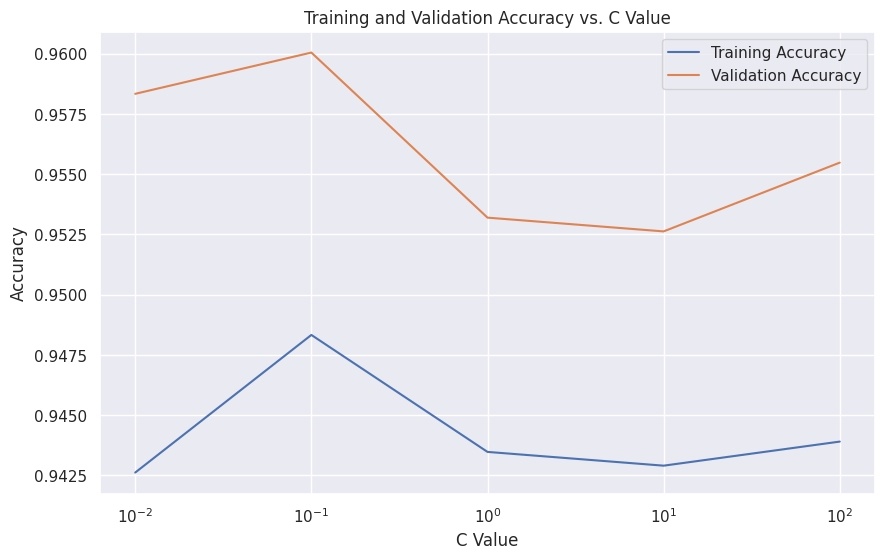

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(logreg_data['C_value'], logreg_data['accuracy_train'], label='Training Accuracy')
plt.plot(logreg_data['C_value'], logreg_data['accuracy_validation'], label='Validation Accuracy')

plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C Value')
plt.xscale('log') # Use a logarithmic scale for the x-axis (C values)
plt.legend()
plt.grid(True)

plt.show()


It looks like the regularization hyperparameter that achieves the highest traning and validation accuracy is C = 1/10. I choose this parameter so that I can capture as much information about my data while also making sure that I don't overfit.

In [ ]:
logreg = LogisticRegression(max_iter  = 100, penalty = 'l2', C= 1/10)
logreg.fit(train_data_imputed, train_target)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [ ]:
logreg_val_prediction = logreg.predict(validation_data_imputed)
logreg_train_prediction = logreg.predict(train_data_imputed)
logreg_val_acc = accuracy_score(logreg_val_prediction, val_target)
logreg_train_acc = accuracy_score(logreg_train_prediction, train_target)

print("logistic training accuracy:", logreg_train_acc)
print("logistic validation accuracy:", logreg_val_acc)

logistic training accuracy: 0.9483300028546959
logistic validation accuracy: 0.9600456621004566


Pretty good accuracies!

# Random Forest Classifier




In [ ]:
# random forest class
import scipy.stats
from sklearn.tree import DecisionTreeClassifier

class RandomForest416:
    """
    This class implements the common sklearn model interface (has a fit and predict function).

    A random forest is a collection of decision trees that are trained on random subsets of the
    dataset. When predicting the value for an example, takes a majority vote from the trees.
    """

    def __init__(self, num_trees, max_depth=1):
        """
        Constructs a RandomForest416 that uses the given numbner of trees, each with a
        max depth of max_depth.
        """
        self.num_trees = num_trees
        self.max_depth = max_depth
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth)
            for i in range(num_trees)
        ]

    def fit(self, X, y):
        """
        Takes an input dataset X and a series of targets y and trains the RandomForest416.

        Each tree will be trained on a random sample of the data that samples the examples
        uniformly at random (with replacement). Each random dataset will have the same number
        of examples as the original dataset, but some examples may be missing or appear more
        than once due to the random sampling with replacement.
        """
        # Q7
        for i, tree in enumerate(self._trees):
            index = np.random.randint(0, len(X), size = len(X))
            #X_sample = X.iloc[index]
            X_sample = X[index]
            y_sample = y.iloc[index]
            train_tree = tree.fit(X_sample, y_sample)

    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)

            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds

        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1, keepdims=False).mode

    def get_params(self, deep=True):
        return {"num_trees": self.num_trees, "max_depth": self.max_depth}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        self._trees = [
            DecisionTreeClassifier(max_depth=self.max_depth)
            for i in range(self.num_trees)
        ]

        return self

Below, I start with a RandomForest416 classifier with an arbitrary set of hyperparameters, say 3 trees with max depth of 3 levels. Let's see how it compares to the one after the grid search

In [ ]:
from sklearn.metrics import accuracy_score

random_forest_test = RandomForest416(3, 3) # 3 trees, max depth 3
random_forest_test.fit(train_data_imputed, train_target)

rf_train_accuracy1 = accuracy_score(random_forest_test.predict(train_data_imputed), train_target)
print("Train accuracy: ", rf_train_accuracy1)
rf_validation_accuracy1 = accuracy_score(random_forest_test.predict(validation_data_imputed), val_target)
print("Validation accuracy: ", rf_validation_accuracy1)


Train accuracy:  0.9459035112760491
Validation accuracy:  0.9577625570776256


In [ ]:
from sklearn.model_selection import GridSearchCV
#Use GridSearchCV to find best settings of hyperparameters

hyperparameters = {'max_depth':[1, 5, 10, 15, 20], 'N_estimators':[1, 5, 10, 15, 20]}
search = GridSearchCV(random_forest_test, hyperparameters, cv = 2, return_train_score = True, scoring = 'accuracy')
search.fit(train_data_imputed, train_target)

GridSearchCV(cv=2,
             estimator=<__main__.RandomForest416 object at 0x787d05c197d0>,
             param_grid={'N_estimators': [1, 5, 10, 15, 20],
                         'max_depth': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy')

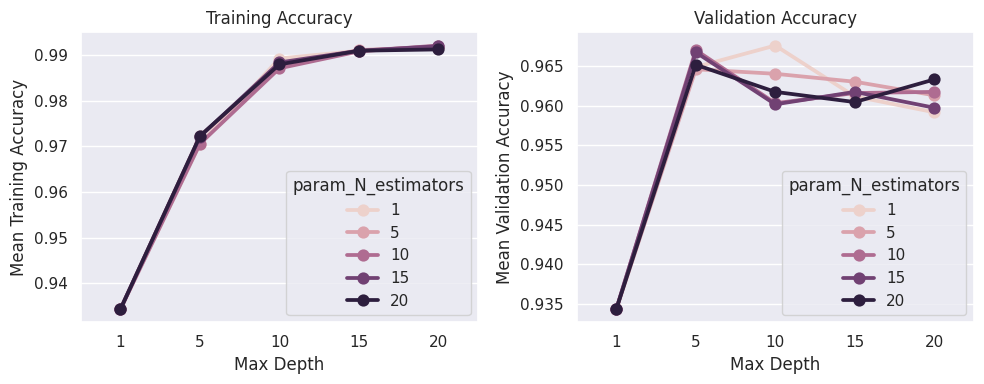

In [ ]:
# prompt: use the gridsearchcv object to make a plot of all the different parameter combination validation and training accuracies. group by param max depth and then by num trees and give the averages of the validation and training accuracies

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'search' is your GridSearchCV object from the provided code
results = pd.DataFrame(search.cv_results_)

# Group by 'param_max_depth' and 'param_N_estimators' and calculate the mean
grouped_results = results.groupby(['param_max_depth', 'param_N_estimators']).agg(
    mean_train_accuracy=('mean_train_score', 'mean'),
    mean_validation_accuracy=('mean_test_score', 'mean')
).reset_index()


# Plotting
plt.figure(figsize=(10, 4))

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
sns.pointplot(x='param_max_depth', y='mean_train_accuracy', hue='param_N_estimators', data=grouped_results)
plt.title('Training Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Mean Training Accuracy')

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
sns.pointplot(x='param_max_depth', y='mean_validation_accuracy', hue='param_N_estimators', data=grouped_results)
plt.title('Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Mean Validation Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
print(search.best_params_)

{'N_estimators': 1, 'max_depth': 10}


In [ ]:
from sklearn.metrics import accuracy_score

random_forest_test = RandomForest416(15, 5) # 15 trees, max depth 5 as evaluated by the grid search
random_forest_test.fit(train_data_imputed, train_target)

rf_train_accuracy = accuracy_score(random_forest_test.predict(train_data_imputed), train_target)
print("Train accuracy: ", rf_train_accuracy)
rf_validation_accuracy = accuracy_score(random_forest_test.predict(validation_data_imputed), val_target)
print("Validation accuracy: ", rf_validation_accuracy)

Train accuracy:  0.9707393662574936
Validation accuracy:  0.9777397260273972


We can see that Grid Search to select the number of trees and max depth improved our accuracies!

In [ ]:
# Final feature list from train data
test_features = ['course_id',
                 #'userid_DI',
                 'registered',
                 'viewed',
                 'explored',
                 #'final_cc_cname_DI',
                 'LoE_DI',
                 'YoB',
                 'gender',
                 #'start_time_DI',
                 #'last_event_DI',
                 'nevents',
                 'ndays_act',
                 'nplay_video',
                 'nchapters',
                 'nforum_posts']

print("Features used for training:", list(train_features))

# --- Process Test Data --- #
df_test = pd.read_csv('edx_test.csv')
df_test_processed = df_test[test_features].copy()

# Transform categorical features in test data using the same encoder
encoded_test = encoder.transform(df_test_processed[categoricals]).toarray()
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categoricals))

# Drop categorical columns and merge with test numerical features
df_test_processed = df_test_processed.drop(columns=categoricals).reset_index(drop=True)
df_test_processed = pd.concat([df_test_processed, encoded_test_df], axis=1)
print("Features used for testing: ", list(df_test_processed.columns))


test_data_imputed = imputer.transform(df_test_processed)

predictions = random_forest_test.predict(test_data_imputed)
print(df_test_processed.shape)


# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
print(to_save.shape)
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.


Features used for training: ['registered', 'viewed', 'explored', 'YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'course_id_HarvardX/CS50x/2012', 'course_id_HarvardX/ER22x/2013_Spring', 'course_id_HarvardX/PH207x/2012_Fall', 'course_id_HarvardX/PH278x/2013_Spring', 'LoE_DI_Doctorate', 'LoE_DI_Less than Secondary', "LoE_DI_Master's", 'LoE_DI_Secondary', 'LoE_DI_nan', 'gender_m', 'gender_nan']
Features used for testing:  ['registered', 'viewed', 'explored', 'YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'course_id_HarvardX/CS50x/2012', 'course_id_HarvardX/ER22x/2013_Spring', 'course_id_HarvardX/PH207x/2012_Fall', 'course_id_HarvardX/PH278x/2013_Spring', 'LoE_DI_Doctorate', 'LoE_DI_Less than Secondary', "LoE_DI_Master's", 'LoE_DI_Secondary', 'LoE_DI_nan', 'gender_m', 'gender_nan']
(2920, 20)
(2920, 1)


### **Discussion**



**Models Used**

I tried a logistic regression classifier model and a random forest classifier model. At first, I made arbitrary guesses for my hyperparameters in both models (regularization parameter C/lambda for logistic regression, varying number of trees and max depth for random forest). Then, I used a loop for the logistic regression model to test out different values of C and record each value's training & validation accuracy. Similary, for the random forest model, I used grid search with 25 different parameter combinations to pick the optimal one. I ultimately chose the hyperparameters that gave me the highest validation accuracies (primarily) and training accuracies.

 **Feature Selection**



I used all of the features except for userid_DI (because there is a unique value for each person, doesn't make much sense to use), certified (because it is the target variable), final_cc_name_DI (because I didn't want my model to predict based on a user's ethnic backgrounds / locations - moreover, sometimes they don't match), and LoE (because I didn't want my model to use a person's level of education to determine whether they are able to complete a course). The main rationale behind the features I selected was to keep as many as possible while also maintaining an equitable algorithm.

**Ethical Implications**



There may be certain stereotypes about nationalities/ethnicities/locations, level of education, and even gender when considering a person's educational background. We must also note that it may be the case that certain groups that may fit these stereotypes have historically been margninalized and underprivileged, so it would not be fair to stereotype them and exclude them from educational initiatives.